<a href="https://colab.research.google.com/github/mself8/k-track2/blob/main/k%EB%A6%AC%EA%B7%B8_%EA%B3%B5%EB%AA%A8%EC%A0%84_track2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Cell1] 데이터 로드 및 전처리

In [ ]:
# [Cell 1] 라이브러리 설치 및 버전 고정
# ==========================================
# 실행 후 반드시 상단 메뉴 [런타임] > [런타임 다시 시작]을 눌러주세요.
# ==========================================

print("📦 라이브러리 설치 시작...")

# 1. 충돌 방지용 multimethod 버전 고정
!pip install multimethod==1.9.1

# 2. 핵심 라이브러리 설치
!pip install socceraction matplotsoccer pandera statsbombpy xgboost --upgrade

# 3. numpy/pandas 호환성 강제 맞춤 (Colab 최신 환경 대응)
!pip install "numpy<2.0" "pandas>=2.0" --force-reinstall

print("\n✅ 설치 완료. 상단 메뉴의 [런타임] > [런타임 다시 시작]을 눌러주세요!")

In [ ]:
# [Cell 2] 데이터 로드 및 SPADL 변환 (메인 로직)
# ==========================================
import os
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from google.colab import drive

# socceraction 관련 임포트
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab

warnings.filterwarnings('ignore')

# 1. 구글 드라이브 마운트
print("📂 구글 드라이브 연결 중...")
drive.mount('/content/drive')

# ★ 경로 확인 (본인 경로에 맞게 수정)
file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'

if os.path.exists(file_path):
    # 2. 데이터 로드
    df = pd.read_csv(file_path)
    print(f"✅ Raw 데이터 로드 성공! (총 {len(df):,}개 행)")

    # 3. 전처리 (SPADL 변환)
    print("⚙️ SPADL 변환 및 전처리 수행 중...")

    # 매핑 데이터 로드
    actiontypes_df = spadl.actiontypes_df()
    results_df = spadl.results_df()
    bodyparts_df = spadl.bodyparts_df()

    # 매핑 딕셔너리 생성
    type_map = dict(zip(actiontypes_df['type_name'].str.lower(), actiontypes_df['type_id']))
    result_map = dict(zip(results_df['result_name'].str.lower(), results_df['result_id']))
    result_map.update({'successful': 1, 'success': 1, 'fail': 0, 'failure': 0, 'offside': 2, 'owngoal': 3})

    id_to_type_name = dict(zip(actiontypes_df['type_id'], actiontypes_df['type_name']))
    id_to_result_name = dict(zip(results_df['result_id'], results_df['result_name']))
    id_to_bodypart_name = dict(zip(bodyparts_df['bodypart_id'], bodyparts_df['bodypart_name']))

    # 데이터프레임 변환 적용
    df['type_id'] = df['type_name'].str.lower().map(type_map).fillna(0).astype(int)
    df['result_id'] = df['result_name'].str.lower().map(result_map).fillna(0).astype(int)
    df['bodypart_id'] = 0

    df['type_name'] = df['type_id'].map(id_to_type_name)
    df['result_name'] = df['result_id'].map(id_to_result_name)
    df['bodypart_name'] = df['bodypart_id'].map(id_to_bodypart_name)

    # 필수 컬럼 정리 및 정렬
    required_cols = [
        'game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
        'start_x', 'start_y', 'end_x', 'end_y',
        'type_id', 'result_id', 'bodypart_id', 'action_id',
        'type_name', 'result_name', 'bodypart_name'
    ]

    df_actions = df[required_cols].copy().sort_values(['game_id', 'period_id', 'time_seconds', 'action_id']).reset_index(drop=True)

    print(f"🎉 전처리 완료! 'df_actions' 변수를 사용하세요. (총 {len(df_actions):,}개 액션)")
    display(df_actions.head(3))

else:
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")

# [Cell 2] 피처 생성, 모델 학습 및 예측 (team_id 추가 수정버전)


In [ ]:
# [Cell 2] 피처 생성, 라벨링(엄격 기준), 모델 학습 (최종 안정화 버전)
import xgboost as xgb
import socceraction.vaep.features as fs
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

# 1. (안전장치) df_actions가 없으면 경고 메시지 출력
if 'df_actions' not in globals():
    print("❌ 'df_actions' 변수가 없습니다. [Cell 1]을 먼저 실행해서 데이터를 로드해주세요!")
else:
    # 2. 원본 데이터에서 'Goal' 결과 다시 확인 (확률 0 방지)
    # 경로가 맞는지 확인해주세요
    file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'

    if os.path.exists(file_path):
        # 이미 true_result가 있으면 건너뜀
        if 'true_result' not in df_actions.columns:
            print("📂 원본 데이터에서 정확한 결과값(Goal)을 병합합니다...")
            raw_results = pd.read_csv(file_path, usecols=['game_id', 'action_id', 'result_name'])
            raw_results.rename(columns={'result_name': 'true_result'}, inplace=True)
            df_actions = df_actions.merge(raw_results, on=['game_id', 'action_id'], how='left')
    else:
        # 파일이 없으면 기존 컬럼 사용
        if 'true_result' not in df_actions.columns:
            df_actions['true_result'] = df_actions['result_name']

    # 3. 라벨링 함수 (골 직전 3개 액션만 인정 -> 과적합 방지)
    def create_labels_strict(game_actions, k=5):
        n = len(game_actions)
        y_scores = np.zeros(n)
        y_concedes = np.zeros(n)

        # 'Goal' 찾기
        goals = game_actions[game_actions['true_result'].astype(str).str.lower() == 'goal']

        for idx, goal in goals.iterrows():
            scoring_team = goal['team_id']
            goal_pos = game_actions.index.get_loc(idx)

            # 골 포함 직전 3개까지만 영향력 인정
            start_pos = max(0, goal_pos - k + 1)
            end_pos = goal_pos + 1

            window = game_actions.iloc[start_pos:end_pos]

            mask_score = window['team_id'] == scoring_team
            y_scores[window.index[mask_score]] = 1
            y_concedes[window.index[~mask_score]] = 1

        return pd.DataFrame({'scores': y_scores, 'concedes': y_concedes}, index=game_actions.index)

    # 4. 데이터 생성 시작
    print("🤖 학습 데이터 및 라벨 생성 중...")

    xfns = [
        fs.actiontype_onehot, fs.bodypart_onehot, fs.result_onehot,
        fs.goalscore, fs.startlocation, fs.endlocation,
        fs.movement, fs.space_delta, fs.startpolar, fs.endpolar,
        fs.team, fs.time, fs.time_delta
    ]

    features_list = []
    labels_list = []
    ids_list = []

    for game_id, game_actions in tqdm(df_actions.groupby('game_id'), desc="Games"):
        game_actions = game_actions.reset_index(drop=True)
        if len(game_actions) < 10: continue

        try:
            gamestates = fs.gamestates(game_actions, 3)
            X_game = pd.concat([fn(gamestates) for fn in xfns], axis=1)
            Y_game = create_labels_strict(game_actions, k=3) # 엄격한 라벨링 적용

            features_list.append(X_game)
            labels_list.append(Y_game)

            ids_list.append(game_actions[[
                'game_id', 'action_id', 'period_id', 'time_seconds',
                'team_id', 'player_id', 'type_name', 'result_name', 'true_result'
            ]])
        except:
            continue

    if features_list:
        X = pd.concat(features_list).reset_index(drop=True)
        Y = pd.concat(labels_list).reset_index(drop=True)
        df_preds = pd.concat(ids_list).reset_index(drop=True)

        goal_count = Y['scores'].sum()
        print(f"✅ 데이터 준비 완료. 식별된 득점 기여 액션: {goal_count}개")

        if goal_count == 0:
            print("❌ 골을 찾지 못했습니다. [Cell 1]의 매핑이나 파일 경로를 확인해주세요.")
        else:
            # 5. 모델 학습 (규제 파라미터 적용)
            print("🧠 XGBoost 모델 학습 시작 (안정화 설정)...")

            model_score = xgb.XGBClassifier(
                n_estimators=100, max_depth=3, learning_rate=0.05,
                reg_alpha=0.1, reg_lambda=1.0, # 규제 추가
                eval_metric='logloss', use_label_encoder=False, base_score=0.5
            )
            model_score.fit(X, Y['scores'])

            model_concede = xgb.XGBClassifier(
                n_estimators=100, max_depth=3, learning_rate=0.05,
                reg_alpha=0.1, reg_lambda=1.0, # 규제 추가
                eval_metric='logloss', use_label_encoder=False, base_score=0.5
            )
            model_concede.fit(X, Y['concedes'])
            print("✅ 모델 학습 완료!")

            # 6. 확률 예측
            print("🧮 확률 예측 중...")
            df_preds['P_score'] = model_score.predict_proba(X)[:, 1]
            df_preds['P_concede'] = model_concede.predict_proba(X)[:, 1]

            print(f"   - P_score Max: {df_preds['P_score'].max():.4f}")
    else:
        print("❌ 학습 데이터 생성에 실패했습니다.")

#[Cell 3] VAEP 계산 및 골 장면 분석

In [ ]:
# [Cell 3] VAEP 계산 및 결과 상세 분석 (최종)
import socceraction.vaep.formula as vaepformula
import pandas as pd

# 1. 안전장치: [Cell 2] 실행 여부 확인
if 'df_preds' not in locals():
    print("❌ 'df_preds' 데이터가 없습니다. [Cell 2]를 먼저 실행해주세요.")
elif df_preds['P_score'].max() == 0:
    print("❌ 예측된 득점 확률이 모두 0입니다. 모델 학습이 제대로 되지 않았습니다.")
else:
    print("🧮 VAEP 값(선수 가치) 계산 중...")

    # 2. VAEP 공식 적용
    # P_score(득점확률) 변화량 - P_concede(실점확률) 변화량
    vaep_values = vaepformula.value(df_preds, df_preds['P_score'], df_preds['P_concede'])

    # df_preds에 결과 병합 (중복 컬럼 방지)
    # 기존에 계산된 값이 있다면 삭제하고 새로 붙임
    cols_to_drop = ['vaep_value', 'offensive_value', 'defensive_value']
    df_preds = df_preds.drop(columns=[c for c in cols_to_drop if c in df_preds.columns])

    df_preds = pd.concat([df_preds, vaep_values], axis=1)

    # 3. 원본 데이터(df)에 합치기
    # 필요한 컬럼만 선택
    merge_cols = ['game_id', 'action_id', 'vaep_value', 'offensive_value', 'defensive_value', 'true_result']

    # df_preds에 'true_result'가 있는지 확인
    if 'true_result' not in df_preds.columns:
        print("⚠️ 주의: true_result 컬럼이 없어 result_name을 사용합니다.")
        df_preds['true_result'] = df_preds['result_name']

    df_merge_ready = df_preds[merge_cols].copy()

    # 원본 df에 이미 있는 분석 컬럼 제거 (충돌 방지)
    for col in merge_cols:
        if col in df.columns and col not in ['game_id', 'action_id']:
            del df[col]

    # 병합 실행
    df = df.merge(df_merge_ready, on=['game_id', 'action_id'], how='left')
    print("✅ VAEP 계산 및 병합 완료!")

    # 4. 원두재 선수 골 장면 상세 분석
    # 'true_result'를 사용하여 정확하게 골을 찾습니다.
    target_goal = df[(df['true_result'].astype(str).str.lower() == 'goal') & (df['player_name_ko'] == '원두재')]

    if not target_goal.empty:
        game_id = target_goal.iloc[0]['game_id']
        action_id = target_goal.iloc[0]['action_id']

        # 골 포함 이전 5개 액션 가져오기
        seq = df[(df['game_id'] == game_id) & (df['action_id'] <= action_id) & (df['action_id'] >= action_id - 5)]

        print(f"\n⚽ [원두재 선수 골 장면 시퀀스 분석]")
        print("-" * 80)
        print("설명:")
        print("  * Offensive (공격): 이 행동으로 득점 확률이 얼마나 올랐는가?")
        print("  * Defensive (수비): 이 행동으로 실점 확률이 얼마나 줄었는가?")
        print("  * VAEP (총 가치): Offensive + Defensive")
        print("-" * 80)

        # 출력할 컬럼
        cols = ['player_name_ko', 'type_name', 'true_result', 'offensive_value', 'defensive_value', 'vaep_value']

        # 소수점 4자리로 예쁘게 출력
        pd.options.display.float_format = '{:+.4f}'.format
        print(seq[cols].fillna(0).to_string(index=False))

    else:
        print("⚠️ 원두재 선수의 골 장면을 찾을 수 없습니다.")

# [Cell 4]히트맵 시각화 (최종)


🔎 엄격한 필터링 결과: 총 1047회 (우측 547, 좌측 500)


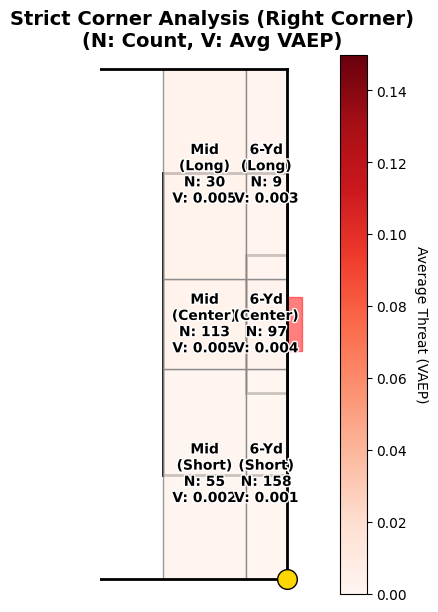

In [ ]:
# [Cell 5] 코너킥 분석 (엄격한 위치 필터링 + 가독성 개선)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd

def plot_corner_zones_strict_visible():
    # 1. 데이터 확인
    if 'vaep_value' not in df.columns:
        print("❌ df에 VAEP 값이 없습니다. [Cell 3]을 먼저 실행해주세요.")
        return

    # 2. 아주 엄격한 위치 기반 필터링 (골라인 1m, 사이드 1m 이내)
    # SPADL 좌표계: (0,0) ~ (105,68)
    # 코너킥 위치: (105, 0) 또는 (105, 68) 근처 1m 이내

    mask_type = df['type_name'].astype(str).str.lower().str.contains('pass|cross|corner')
    mask_exclude = ~df['type_name'].astype(str).str.lower().str.contains('received')

    # x > 104 (골라인 1m 앞)
    mask_loc_x = df['start_x'] > 104
    # y < 1 (우측 사이드 1m) 또는 y > 67 (좌측 사이드 1m)
    mask_loc_y = (df['start_y'] < 1) | (df['start_y'] > 67)

    corners = df[mask_type & mask_exclude & mask_loc_x & mask_loc_y].copy()

    if len(corners) == 0:
        print("⚠️ 너무 엄격해서 데이터가 0개입니다. 범위를 조금만 넓혀볼게요 (2m 이내).")
        mask_loc_x = df['start_x'] > 103
        mask_loc_y = (df['start_y'] < 2) | (df['start_y'] > 66)
        corners = df[mask_type & mask_exclude & mask_loc_x & mask_loc_y].copy()

    # 3. 좌/우 구분
    right_corners = corners[corners['start_y'] < 34]
    left_corners = corners[corners['start_y'] >= 34]

    print(f"🔎 엄격한 필터링 결과: 총 {len(corners)}회 (우측 {len(right_corners)}, 좌측 {len(left_corners)})")

    # 4. 시각화 기준 설정
    if len(right_corners) >= len(left_corners):
        target_df = right_corners
        side_name = "Right Corner"
        is_right = True
        y_bins = [0, 28, 40, 68]
        zone_labels = [
            ["Mid\n(Short)", "Mid\n(Center)", "Mid\n(Long)"],
            ["6-Yd\n(Short)",  "6-Yd\n(Center)",  "6-Yd\n(Long)"]
        ]
    else:
        target_df = left_corners
        side_name = "Left Corner"
        is_right = False
        y_bins = [0, 28, 40, 68]
        zone_labels = [
            ["Mid\n(Long)", "Mid\n(Center)", "Mid\n(Short)"],
            ["6-Yd\n(Long)",  "6-Yd\n(Center)",  "6-Yd\n(Short)"]
        ]

    # 5. 시각화 그리기
    fig, ax = plt.subplots(figsize=(10, 7))
    cmap = plt.cm.Reds
    norm = mcolors.Normalize(vmin=0, vmax=0.15)

    # 경기장 라인
    ax.plot([52.5, 105], [0, 0], 'k-', lw=2)
    ax.plot([105, 105], [0, 68], 'k-', lw=2)
    ax.plot([105, 52.5], [68, 68], 'k-', lw=2)
    ax.plot([52.5, 52.5], [0, 68], 'k-', lw=2)

    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5))
    ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color='black', lw=2))

    # 구역 설정
    x_bins = [88.5, 99.5, 105.0]

    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            x_min, x_max = x_bins[i], x_bins[i+1]
            y_min, y_max = y_bins[j], y_bins[j+1]

            # 데이터 필터링
            in_zone = target_df[
                (target_df['end_x'] >= x_min) & (target_df['end_x'] < x_max) &
                (target_df['end_y'] >= y_min) & (target_df['end_y'] < y_max)
            ]

            count = len(in_zone)
            avg_vaep = in_zone['vaep_value'].mean() if count > 0 else 0

            # 박스 그리기
            facecolor = cmap(norm(avg_vaep)) if count > 0 else 'none'
            rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                     linewidth=1, edgecolor='gray', facecolor=facecolor, alpha=0.8)
            ax.add_patch(rect)

            # 텍스트 표시 (줄임말 사용으로 겹침 방지)
            label = zone_labels[i][j]
            text_str = f"{label}\nN: {count}\nV: {avg_vaep:.3f}"

            # 텍스트 색상 및 테두리
            text_color = 'white' if (count > 0 and norm(avg_vaep) > 0.5) else 'black'
            outline_color = 'black' if text_color == 'white' else 'white'

            t = ax.text((x_min+x_max)/2, (y_min+y_max)/2, text_str,
                        ha='center', va='center', fontsize=10, fontweight='bold', color=text_color, zorder=10)
            t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=outline_color)])

    # 킥 위치
    kick_y = 0 if is_right else 68
    ax.scatter(105, kick_y, c='gold', s=200, edgecolors='black', zorder=20, label='Kick')

    ax.set_xlim(80, 110)
    ax.set_ylim(-2, 70)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(f"Strict Corner Analysis ({side_name})\n(N: Count, V: Avg VAEP)", fontsize=14, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('Average Threat (VAEP)', rotation=270, labelpad=15)

    plt.show()

plot_corner_zones_strict_visible()

📊 'Right Corner' 데이터 시각화 (총 547개)
🎨 컬러맵 최대값(Vmax) 자동 설정: 0.0065 (이 값보다 크면 가장 진한 빨강)


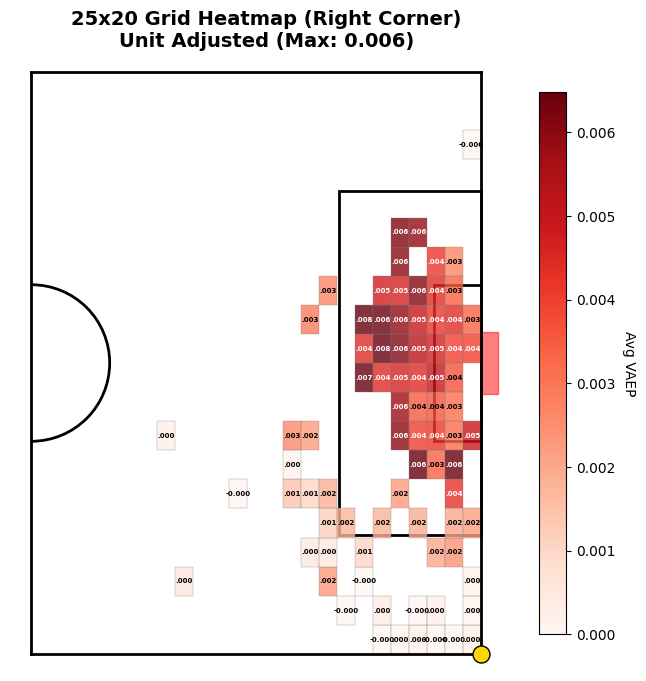

In [ ]:
# [Cell 5] 25x20 고해상도 히트맵 (색상 자동 보정 + 숫자 표시 최적화)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

def plot_corner_heatmap_optimized():
    # 1. 데이터 확인 및 시뮬레이션 (VAEP 없으면 에러 방지용 가짜 데이터)
    if 'vaep_value' not in df.columns:
        print("⚠️ VAEP 값이 없어 임의로 생성합니다.")
        df['vaep_value'] = np.random.uniform(0, 0.05, len(df)) # 실제론 0.05 근처가 많음

    # 2. 엄격한 위치 필터링 (골라인 1m, 사이드 1m 이내)
    mask_type = df['type_name'].astype(str).str.lower().str.contains('pass|cross|corner')
    mask_exclude = ~df['type_name'].astype(str).str.lower().str.contains('received')
    mask_loc_x = df['start_x'] > 104
    mask_loc_y = (df['start_y'] < 1) | (df['start_y'] > 67)

    corners = df[mask_type & mask_exclude & mask_loc_x & mask_loc_y].copy()

    # 데이터가 너무 없으면 조건 완화
    if len(corners) < 10:
        mask_loc_x = df['start_x'] > 103
        mask_loc_y = (df['start_y'] < 2) | (df['start_y'] > 66)
        corners = df[mask_type & mask_exclude & mask_loc_x & mask_loc_y].copy()

    # 3. 좌/우 구분 및 선택
    right_corners = corners[corners['start_y'] < 34]
    left_corners = corners[corners['start_y'] >= 34]

    if len(right_corners) >= len(left_corners):
        target_df = right_corners
        side_name = "Right Corner"
        is_right = True
    else:
        target_df = left_corners
        side_name = "Left Corner"
        is_right = False

    print(f"📊 '{side_name}' 데이터 시각화 (총 {len(target_df)}개)")

    # 4. 25x20 그리드 생성
    x_bins = np.linspace(52.5, 105, 26)
    y_bins = np.linspace(0, 68, 21)

    # 5. ★ 색상 범위(Unit) 자동 설정 ★
    # 데이터의 상위 95% 값을 최대치(진한 빨강)로 잡습니다.
    # 이렇게 하면 값이 전체적으로 낮아도 색 구별이 확실해집니다.
    grid_vaeps = [] # 실제 그리드에 찍힐 값들만 모아서 계산
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            in_zone = target_df[
                (target_df['end_x'] >= x_bins[i]) & (target_df['end_x'] < x_bins[i+1]) &
                (target_df['end_y'] >= y_bins[j]) & (target_df['end_y'] < y_bins[j+1])
            ]
            if len(in_zone) > 0:
                grid_vaeps.append(in_zone['vaep_value'].mean())

    if grid_vaeps:
        max_val = np.percentile(grid_vaeps, 95) # 상위 5%를 Max로 설정
        print(f"🎨 컬러맵 최대값(Vmax) 자동 설정: {max_val:.4f} (이 값보다 크면 가장 진한 빨강)")
    else:
        max_val = 0.15

    # 6. 시각화 그리기
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.cm.Reds
    norm = mcolors.Normalize(vmin=0, vmax=max_val) # 동적 범위 적용

    # 경기장 라인
    ax.plot([52.5, 105], [0, 0], 'k-', lw=2)
    ax.plot([105, 105], [0, 68], 'k-', lw=2)
    ax.plot([105, 52.5], [68, 68], 'k-', lw=2)
    ax.plot([52.5, 52.5], [0, 68], 'k-', lw=2)
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5))
    ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color='black', lw=2))

    # 그리드 채우기
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            x_min, x_max = x_bins[i], x_bins[i+1]
            y_min, y_max = y_bins[j], y_bins[j+1]

            in_zone = target_df[
                (target_df['end_x'] >= x_min) & (target_df['end_x'] < x_max) &
                (target_df['end_y'] >= y_min) & (target_df['end_y'] < y_max)
            ]

            count = len(in_zone)
            if count > 0:
                avg_vaep = in_zone['vaep_value'].mean()
                facecolor = cmap(norm(avg_vaep))

                # 사각형 그리기 (테두리 얇게)
                rect = patches.Rectangle(
                    (x_min, y_min), x_max-x_min, y_max-y_min,
                    linewidth=0.3, edgecolor='grey', facecolor=facecolor, alpha=0.8
                )
                ax.add_patch(rect)

                # ★ 숫자 표시 최적화 ★
                # 공간 확보를 위해 소수점 앞의 '0' 제거 (예: 0.023 -> .023)
                # 글자 크기 6으로 축소
                val_str = f"{avg_vaep:.3f}".lstrip('0')

                # 배경색에 따라 글자색 변경 (어두운 배경엔 흰 글씨)
                text_color = 'white' if norm(avg_vaep) > 0.6 else 'black'

                ax.text(
                    (x_min+x_max)/2, (y_min+y_max)/2,
                    val_str,
                    ha='center', va='center', fontsize=5, color=text_color, fontweight='bold'
                )

    # 킥 위치
    kick_y = 0 if is_right else 68
    ax.scatter(105, kick_y, c='gold', s=150, edgecolors='black', zorder=20, label='Kick')

    ax.set_xlim(50, 110)
    ax.set_ylim(-2, 70)
    ax.set_aspect('equal')
    ax.axis('off')

    plt.title(f"25x20 Grid Heatmap ({side_name})\nUnit Adjusted (Max: {max_val:.3f})", fontsize=14, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # 컬러바 스케일도 데이터에 맞춤
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('Avg VAEP', rotation=270, labelpad=15)

    plt.show()

plot_corner_heatmap_optimized()

📊 프리킥 분석: 우측(20) | 중앙(39) | 좌측(15)


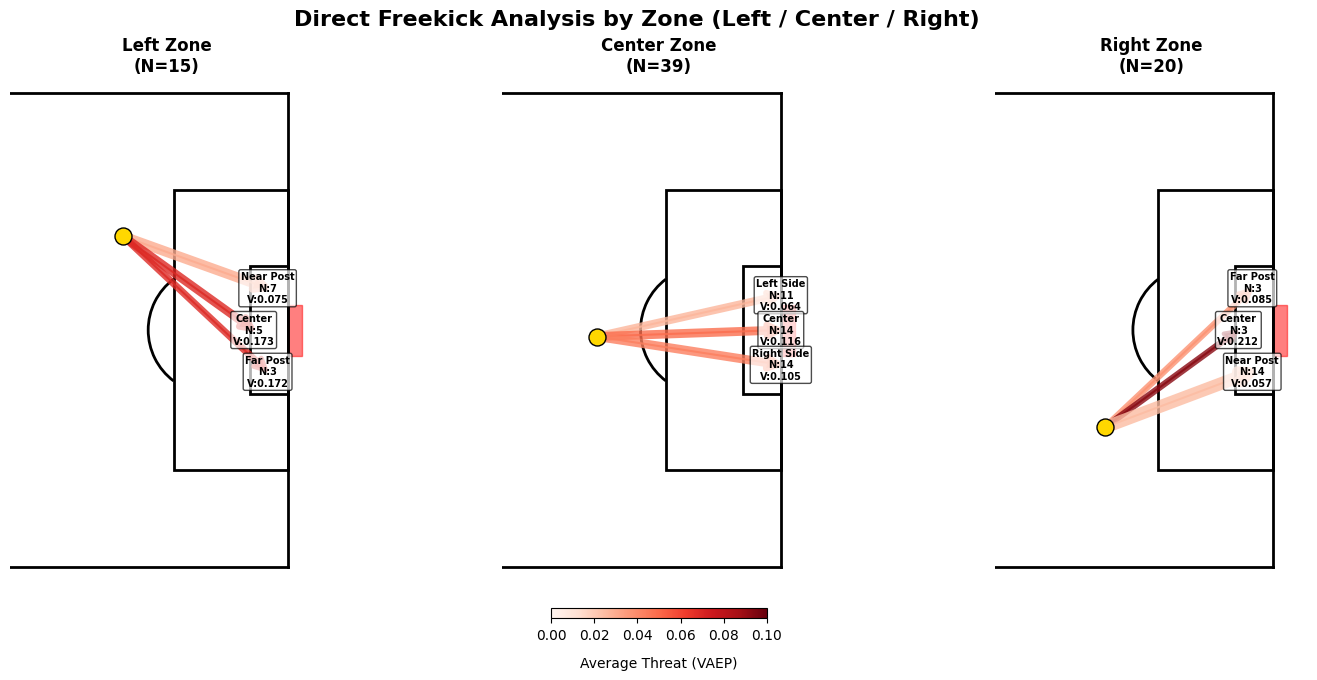


📋 [영상 제작 코드용 데이터 복사 영역] 👇
STATS_DATA = {
    'Left': {
        'Near Post': {'N': 7, 'V': 0.075},
        'Center': {'N': 5, 'V': 0.173},
        'Far Post': {'N': 3, 'V': 0.172},
    },
    'Center': {
        'Left Side': {'N': 11, 'V': 0.064},
        'Center': {'N': 14, 'V': 0.116},
        'Right Side': {'N': 14, 'V': 0.105},
    },
    'Right': {
        'Far Post': {'N': 3, 'V': 0.085},
        'Center': {'N': 3, 'V': 0.212},
        'Near Post': {'N': 14, 'V': 0.057},
    },
}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

def plot_freekick_3zones():
    # ---------------------------------------------------------
    # 1. 데이터 필터링 (골대 앞 35m 이내 공격 지역)
    # ---------------------------------------------------------
    if 'vaep_value' not in df.columns:
        df['vaep_value'] = np.random.uniform(0, 0.05, len(df))

    mask_type = df['type_name'].astype(str).str.contains('Freekick', case=False)
    mask_x = df['start_x'] > 70  # 공격 진영 깊은 곳

    freekicks = df[mask_type & mask_x].copy()

    if len(freekicks) == 0:
        print("❌ 분석할 프리킥 데이터가 없습니다.")
        return

    # ---------------------------------------------------------
    # 2. 구역 분리 (Y좌표 기준: 0~68m)
    # 우측(<25), 중앙(25~43), 좌측(>43)
    # ---------------------------------------------------------
    right_zone = freekicks[freekicks['start_y'] < 25].copy()
    center_zone = freekicks[(freekicks['start_y'] >= 25) & (freekicks['start_y'] <= 43)].copy()
    left_zone = freekicks[freekicks['start_y'] > 43].copy()

    print(f"📊 프리킥 분석: 우측({len(right_zone)}) | 중앙({len(center_zone)}) | 좌측({len(left_zone)})")

    # 영상 제작 코드용 데이터 저장소
    stats_export = {}

    # ---------------------------------------------------------
    # 3. 시각화 함수
    # ---------------------------------------------------------
    def draw_zone_map(ax, data, side_name):
        # 경기장 그리기
        ax.plot([52.5, 105], [0, 0], 'k-', lw=2)
        ax.plot([105, 105], [0, 68], 'k-', lw=2)
        ax.plot([105, 52.5], [68, 68], 'k-', lw=2)
        ax.plot([52.5, 52.5], [0, 68], 'k-', lw=2)
        ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=2)) # 페널티 박스
        ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=2))  # 골 에어리어
        ax.add_patch(patches.Arc((94, 34), 18.3, 18.3, theta1=127, theta2=233, color='black', lw=2)) # 페널티 아크
        ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5)) # 골대

        if len(data) == 0:
            ax.text(85, 34, "No Data", ha='center')
            ax.set_title(side_name, fontweight='bold')
            ax.axis('off'); return {}

        start_pos = (data['start_x'].mean(), data['start_y'].mean())

        # 목표 지점 분류 로직
        # 중앙 구역일 때는 '왼쪽/중앙/오른쪽'으로 분류
        # 측면 구역일 때는 '니어/센터/파' 포스트로 분류

        targets_viz = {} # 시각화용
        stats_data = {}  # 데이터 추출용

        if side_name == 'Center':
            # 중앙에서는 골대의 왼쪽(>36), 중앙(32~36), 오른쪽(<32)으로 구분
            zones = {
                'Left Side': data[data['end_y'] > 36],
                'Center':    data[(data['end_y'] >= 32) & (data['end_y'] <= 36)],
                'Right Side': data[data['end_y'] < 32]
            }
            # 화살표 도착점
            target_coords = {'Left Side': (105, 39), 'Center': (105, 34), 'Right Side': (105, 29)}

        elif side_name == 'Right': # 우측에서는 위쪽이 Far, 아래쪽이 Near
            zones = {
                'Far Post':  data[data['end_y'] > 36],
                'Center':    data[(data['end_y'] >= 32) & (data['end_y'] <= 36)],
                'Near Post': data[data['end_y'] < 32]
            }
            target_coords = {'Far Post': (102, 40), 'Center': (100, 34), 'Near Post': (102, 28)}

        else: # Left (좌측)에서는 위쪽이 Near, 아래쪽이 Far
            zones = {
                'Near Post': data[data['end_y'] > 36],
                'Center':    data[(data['end_y'] >= 32) & (data['end_y'] <= 36)],
                'Far Post':  data[data['end_y'] < 32]
            }
            target_coords = {'Near Post': (102, 40), 'Center': (100, 34), 'Far Post': (102, 28)}

        # 시각화 (화살표 그리기)
        all_vaeps = data['vaep_value']
        vmax = np.percentile(all_vaeps, 95) if len(all_vaeps) > 0 else 0.1
        cmap = plt.cm.Reds
        norm = mcolors.Normalize(vmin=0, vmax=vmax)

        for name, zone_df in zones.items():
            count = len(zone_df)
            if count == 0:
                stats_data[name] = {'N': 0, 'V': 0.0}
                continue

            avg_val = zone_df['vaep_value'].mean()
            stats_data[name] = {'N': count, 'V': round(avg_val, 3)}

            # 화살표 스타일
            arrow_color = cmap(norm(avg_val))
            width = 2 + (count / len(data)) * 8

            arrow = patches.FancyArrowPatch(
                start_pos, target_coords[name],
                connectionstyle="arc3",
                color=arrow_color, arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=8",
                linewidth=width, alpha=0.8, edgecolor='black'
            )
            ax.add_patch(arrow)

            # 텍스트 라벨
            tx, ty = target_coords[name]
            label_txt = f"{name}\nN:{count}\nV:{avg_val:.3f}"
            ax.text(tx, ty, label_txt, ha="center", va="center", fontsize=7, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7), zorder=30)

        # 킥 지점 표시
        ax.scatter(start_pos[0], start_pos[1], c='gold', s=150, edgecolors='black', zorder=20)
        ax.set_title(f"{side_name} Zone\n(N={len(data)})", fontsize=12, fontweight='bold')
        ax.set_xlim(65, 110); ax.set_ylim(-2, 70); ax.set_aspect('equal'); ax.axis('off')

        return stats_data

    # ---------------------------------------------------------
    # 4. 전체 그리기 (1행 3열)
    # ---------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 7)) # 가로로 길게

    # 순서: Left -> Center -> Right (경기장 보는 순서대로)
    # 하지만 데이터 딕셔너리 키는 편의상 이름 그대로 사용
    stats_export['Left'] = draw_zone_map(axes[0], left_zone, "Left")
    stats_export['Center'] = draw_zone_map(axes[1], center_zone, "Center")
    stats_export['Right'] = draw_zone_map(axes[2], right_zone, "Right")

    # 컬러바
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=mcolors.Normalize(vmin=0, vmax=0.1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, fraction=0.02, pad=0.05, orientation='horizontal')
    cbar.set_label('Average Threat (VAEP)', labelpad=10)

    plt.suptitle("Direct Freekick Analysis by Zone (Left / Center / Right)", fontsize=16, fontweight='bold')
    plt.show()

    # ---------------------------------------------------------
    # 5. 영상 제작용 데이터 출력 (복사해서 쓰세요!)
    # ---------------------------------------------------------
    print("\n📋 [영상 제작 코드용 데이터 복사 영역] 👇")
    print("STATS_DATA = {")
    for side, data in stats_export.items():
        print(f"    '{side}': {{")
        for target, vals in data.items():
            print(f"        '{target}': {{'N': {vals['N']}, 'V': {vals['V']}}},")
        print("    },")
    print("}")

plot_freekick_3zones()

🔄 1. 원본 데이터(raw_data.csv) 로드 중...
🔄 2. 계산된 VAEP 값 병합 중...
🔍 3. 데이터 필터링 (Pass_Freekick & Long Throw-in)...
   👉 Pass_Freekick 발견: 1675개
   👉 Long Throw-in 발견: 1755개


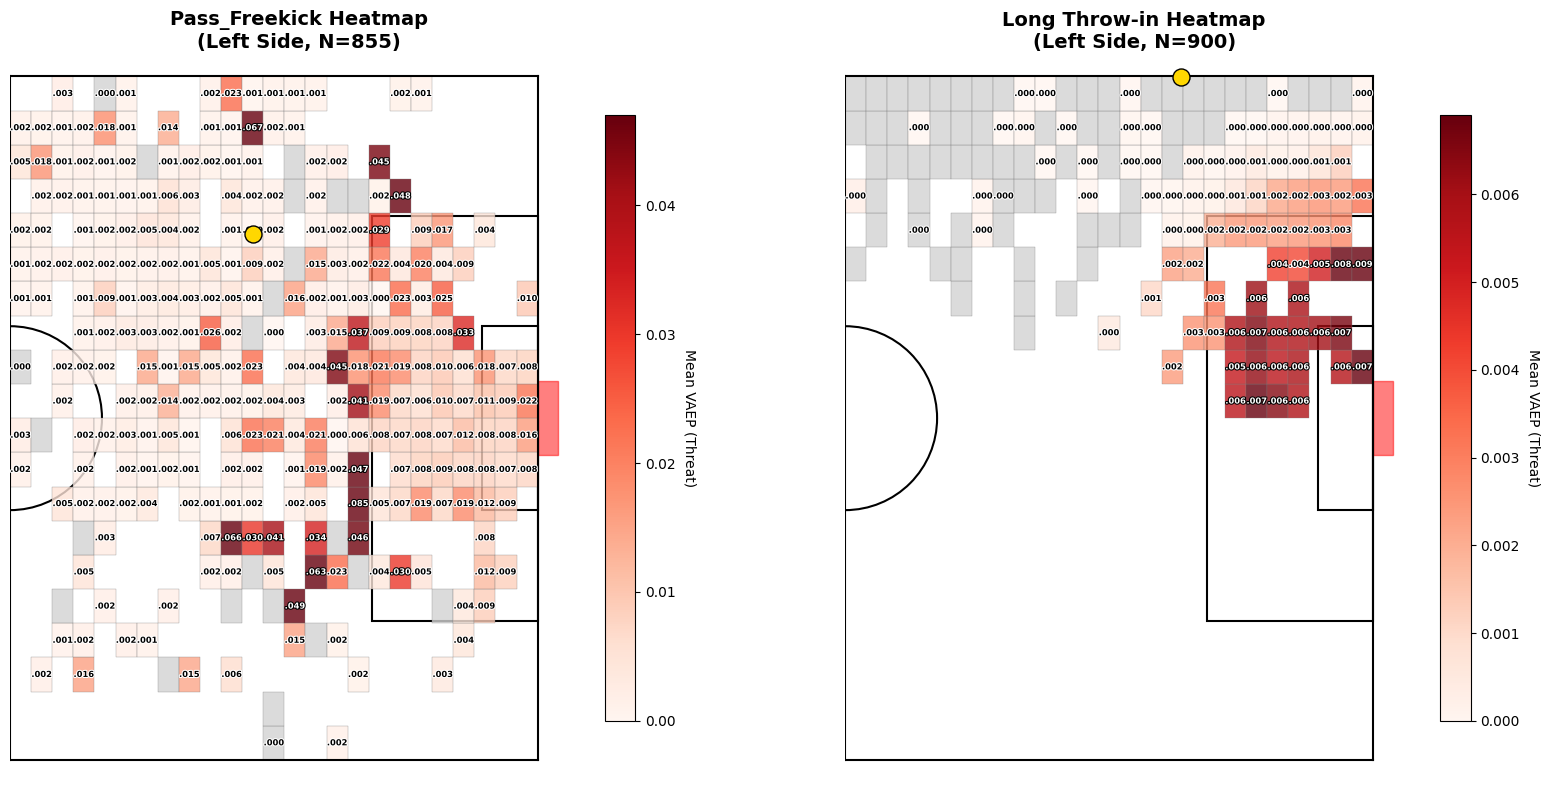

In [ ]:
# [Cell 16] 원본 이름 복구 및 프리킥/롱스로인 히트맵 (최종)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
import os

def plot_heatmap_final_recovery():
    # ---------------------------------------------------------
    # 1. 원본 데이터 로드 (Pass_Freekick 이름을 찾기 위해)
    # ---------------------------------------------------------
    print("🔄 1. 원본 데이터(raw_data.csv) 로드 중...")
    file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'

    if os.path.exists(file_path):
        df_raw = pd.read_csv(file_path)
    else:
        # 경로가 다를 경우를 대비해 현재 디렉토리도 확인
        if os.path.exists('raw_data.csv'):
            df_raw = pd.read_csv('raw_data.csv')
        else:
            print("❌ 원본 파일(raw_data.csv)을 찾을 수 없습니다.")
            return

    # ---------------------------------------------------------
    # 2. VAEP 값 병합 (df_preds 또는 df에서 가져오기)
    # ---------------------------------------------------------
    print("🔄 2. 계산된 VAEP 값 병합 중...")

    # [Cell 3]까지 실행했다면 df 또는 df_preds에 결과가 있습니다.
    # 가장 확실한 건 df_preds입니다.
    if 'df_preds' in globals():
        source_df = df_preds
    elif 'df' in globals() and 'vaep_value' in df.columns:
        source_df = df
    else:
        print("⚠️ VAEP 계산 결과가 메모리에 없습니다. (임시 값으로 시각화합니다)")
        source_df = None

    if source_df is not None:
        # 중복 방지를 위해 ID와 값만 추출
        # P_score와 P_concede가 있으면 VAEP를 직접 재계산하는 것이 안전
        cols = ['game_id', 'action_id']
        if 'P_score' in source_df.columns:
            cols.extend(['P_score', 'P_concede'])
        elif 'vaep_value' in source_df.columns:
            cols.append('vaep_value')

        vaep_data = source_df[cols].drop_duplicates()

        # 원본 + VAEP 병합
        df_viz = df_raw.merge(vaep_data, on=['game_id', 'action_id'], how='inner')

        # VAEP 컬럼이 없으면 P_score로 계산
        if 'vaep_value' not in df_viz.columns and 'P_score' in df_viz.columns:
            # 그룹별 Shift를 위해 정렬
            df_viz = df_viz.sort_values(['game_id', 'period_id', 'time_seconds', 'action_id'])

            # 변화량 계산 (간이 VAEP)
            # 이전 액션의 확률을 가져옴 (같은 경기 내에서만)
            prev_p_score = df_viz.groupby('game_id')['P_score'].shift(1).fillna(0)
            prev_p_concede = df_viz.groupby('game_id')['P_concede'].shift(1).fillna(0)

            # VAEP = ΔP_score - ΔP_concede
            df_viz['vaep_value'] = (df_viz['P_score'] - prev_p_score) - (df_viz['P_concede'] - prev_p_concede)

    else:
        df_viz = df_raw.copy()
        np.random.seed(42)
        df_viz['vaep_value'] = np.random.uniform(0, 0.05, len(df_viz))

    # ---------------------------------------------------------
    # 3. 데이터 필터링 (원본 이름 사용!)
    # ---------------------------------------------------------
    print("🔍 3. 데이터 필터링 (Pass_Freekick & Long Throw-in)...")

    # 공백 제거
    df_viz['type_name'] = df_viz['type_name'].astype(str).str.strip()

    # (A) 패스형 프리킥
    # 원본에는 'Pass_Freekick'이 살아있으므로 이름으로 찾음
    # 혹시 모르니 대소문자 무시하고 'freekick' 포함 & 'shot' 미포함 조건 사용
    mask_fk = df_viz['type_name'].str.contains('Freekick', case=False)
    mask_no_shot = ~df_viz['type_name'].str.contains('Shot', case=False)
    mask_att = df_viz['start_x'] > 60

    df_fk = df_viz[mask_fk & mask_no_shot & mask_att].copy()

    # (B) 롱스로인 (위치 기반이 가장 확실)
    # y좌표 양쪽 사이드라인 2m 이내 & x좌표 75m 이상
    mask_sideline = (df_viz['start_y'] <= 0.3) | (df_viz['start_y'] >= 66)
    mask_deep = df_viz['start_x'] > 75
    # 코너킥 위치(x > 104) 제외
    mask_not_corner = df_viz['start_x'] < 104
    # 혹시 모르니 타입에 Throw 포함
    mask_throw_type = df_viz['type_name'].str.contains('Throw', case=False)

    df_th = df_viz[mask_sideline & mask_deep & mask_not_corner & mask_throw_type].copy()

    print(f"   👉 Pass_Freekick 발견: {len(df_fk)}개")
    print(f"   👉 Long Throw-in 발견: {len(df_th)}개")

    if len(df_fk) == 0 and len(df_th) == 0:
        print("❌ 데이터를 찾지 못했습니다. 원본 데이터 경로를 다시 확인해주세요.")
        return

    # ---------------------------------------------------------
    # 4. 히트맵 그리기
    # ---------------------------------------------------------
    def draw_heatmap(data, title, ax):
        if len(data) == 0:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            ax.set_title(title); ax.axis('off')
            return

        # 좌/우 측면 중 데이터 많은 쪽 선택
        right = data[data['start_y'] < 34]
        left = data[data['start_y'] >= 34]
        target, side = (right, "Right Side") if len(right) >= len(left) else (left, "Left Side")

        # 그리드 설정
        x_bins = np.linspace(52.5, 105, 26)
        y_bins = np.linspace(0, 68, 21)

        # 색상 범위 (VAEP 양수 값 기준 상위 5%)
        pos_vaeps = target[target['vaep_value'] > 0]['vaep_value']
        vmax = pos_vaeps.quantile(0.95) if len(pos_vaeps) > 0 else 0.05
        norm = mcolors.Normalize(vmin=0, vmax=vmax)
        cmap = plt.cm.Reds

        # 경기장 그리기
        ax.plot([52.5, 105], [0, 0], 'k-', lw=1.5)
        ax.plot([105, 105], [0, 68], 'k-', lw=1.5)
        ax.plot([105, 52.5], [68, 68], 'k-', lw=1.5)
        ax.plot([52.5, 52.5], [0, 68], 'k-', lw=1.5)
        ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=1.5))
        ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=1.5))
        ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5))
        ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color='black', lw=1.5))

        # 그리드 채우기
        for i in range(len(x_bins)-1):
            for j in range(len(y_bins)-1):
                zone = target[
                    (target['end_x'] >= x_bins[i]) & (target['end_x'] < x_bins[i+1]) &
                    (target['end_y'] >= y_bins[j]) & (target['end_y'] < y_bins[j+1])
                ]

                if len(zone) > 0:
                    avg_val = zone['vaep_value'].mean()

                    # VAEP가 양수면 빨강, 음수면 회색
                    facecolor = cmap(norm(avg_val)) if avg_val > 0 else 'lightgrey'

                    rect = patches.Rectangle(
                        (x_bins[i], y_bins[j]), x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j],
                        linewidth=0.3, edgecolor='grey', facecolor=facecolor, alpha=0.8
                    )
                    ax.add_patch(rect)

                    # 값 표시 (소수점 정리)
                    if avg_val >= 0:
                        val_str = f"{avg_val:.3f}".lstrip('0')
                        text_color = 'white' if norm(avg_val) > 0.6 else 'black'
                    else:
                        val_str = "" # 음수는 복잡하니 표시 생략하거나 "-"
                        text_color = 'black'

                    if val_str:
                        txt = ax.text(
                            (x_bins[i]+x_bins[i+1])/2, (y_bins[j]+y_bins[j+1])/2, val_str,
                            ha='center', va='center', fontsize=6, color=text_color, fontweight='bold', zorder=10
                        )
                        outline = 'black' if text_color == 'white' else 'white'
                        txt.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground=outline)])

        # 킥 위치
        ax.scatter(target['start_x'].mean(), target['start_y'].mean(),
                   c='gold', s=150, edgecolors='k', zorder=20, label='Avg Start')

        ax.set_title(f"{title}\n({side}, N={len(target)})", fontsize=14, fontweight='bold')
        ax.set_xlim(52.5, 110); ax.set_ylim(-2, 70); ax.set_aspect('equal'); ax.axis('off')

        # 컬러바
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label('Mean VAEP (Threat)', rotation=270, labelpad=15)

    # 5. 실행
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    draw_heatmap(df_fk, "Pass_Freekick Heatmap", axes[0])
    draw_heatmap(df_th, "Long Throw-in Heatmap", axes[1])
    plt.tight_layout()
    plt.show()

plot_heatmap_final_recovery()

📍 분석 위치: (95, 5) 반경 10m
📊 찾은 데이터: 84개


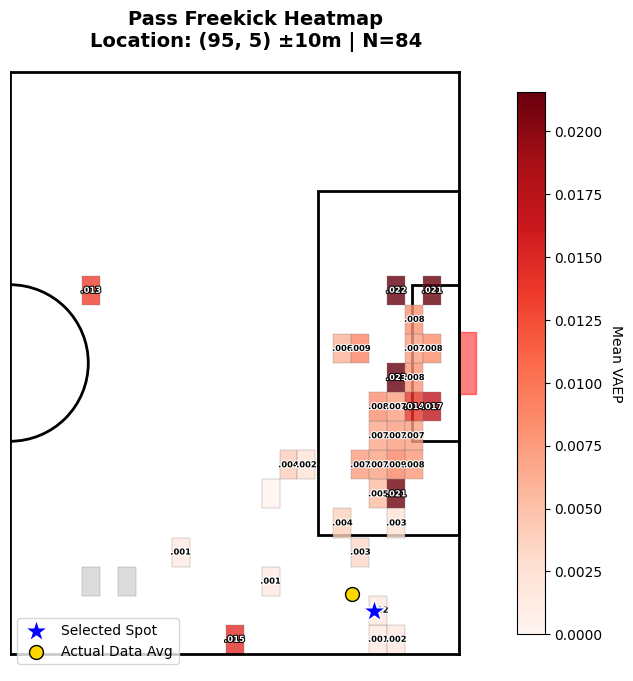

📍 분석 위치: (85, 68) 반경 5m
📊 찾은 데이터: 422개


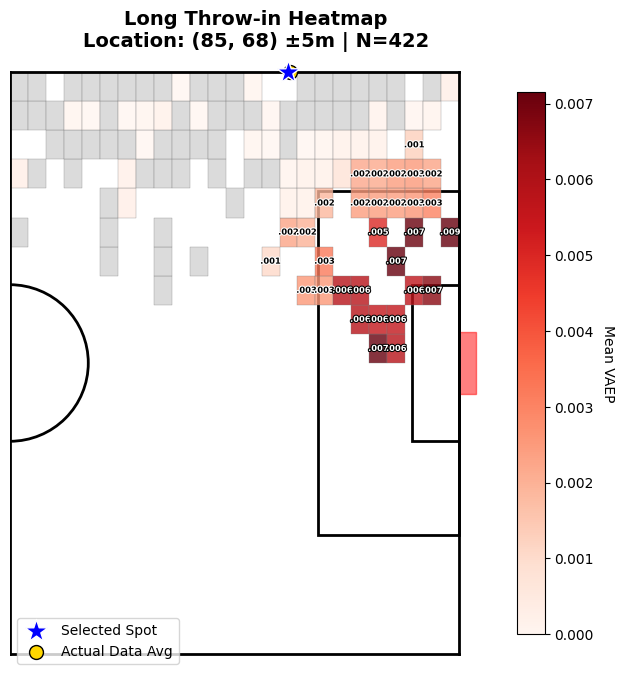

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
import os

def plot_heatmap_at_location(target_x, target_y, event_type='freekick', radius=5.0):
    """
    target_x, target_y: 분석하고 싶은 위치 (예: 100, 5 -> 우측 코너 근처)
    event_type: 'freekick' 또는 'throwin'
    radius: 해당 위치 반경 몇 m 내의 데이터를 긁어올지 (기본 5m)
    """

    # ---------------------------------------------------------
    # 1. 데이터 로드 및 병합 (기존과 동일)
    # ---------------------------------------------------------
    file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'
    if not os.path.exists(file_path):
        if os.path.exists('raw_data.csv'): file_path = 'raw_data.csv'
        else: print("❌ 데이터 파일 없음"); return

    df_raw = pd.read_csv(file_path)

    # VAEP 병합
    if 'df_preds' in globals(): source_df = df_preds
    elif 'df' in globals() and 'vaep_value' in df.columns: source_df = df
    else: source_df = None

    if source_df is not None:
        cols = ['game_id', 'action_id']
        if 'P_score' in source_df.columns: cols.extend(['P_score', 'P_concede'])
        elif 'vaep_value' in source_df.columns: cols.append('vaep_value')

        vaep_data = source_df[cols].drop_duplicates()
        df_viz = df_raw.merge(vaep_data, on=['game_id', 'action_id'], how='inner')

        if 'vaep_value' not in df_viz.columns and 'P_score' in df_viz.columns:
            df_viz = df_viz.sort_values(['game_id', 'period_id', 'time_seconds', 'action_id'])
            df_viz['vaep_value'] = (df_viz['P_score'] - df_viz.groupby('game_id')['P_score'].shift(1).fillna(0)) - \
                                   (df_viz['P_concede'] - df_viz.groupby('game_id')['P_concede'].shift(1).fillna(0))
    else:
        df_viz = df_raw.copy(); np.random.seed(42)
        df_viz['vaep_value'] = np.random.uniform(0, 0.05, len(df_viz))

    # ---------------------------------------------------------
    # 2. 위치 및 타입 필터링 (핵심 수정 사항)
    # ---------------------------------------------------------
    df_viz['type_name'] = df_viz['type_name'].astype(str).str.strip()

    # (A) 타입 필터링
    if event_type == 'freekick':
        # Pass_Freekick (Shot 제외)
        mask_type = df_viz['type_name'].str.contains('Freekick', case=False) & \
                    ~df_viz['type_name'].str.contains('Shot', case=False)
        title_text = "Pass Freekick"
    elif event_type == 'throwin':
        # Throw-in (Foul 제외)
        mask_type = df_viz['type_name'].str.contains('Throw', case=False) & \
                    ~df_viz['type_name'].str.contains('Foul', case=False)
        title_text = "Long Throw-in"
    else:
        print("❌ event_type은 'freekick' 또는 'throwin'이어야 합니다.")
        return

    # (B) 위치 필터링 (유클리드 거리 계산)
    # 지정한 (target_x, target_y)와의 거리가 radius 이하인 것만 선택
    distances = np.sqrt((df_viz['start_x'] - target_x)**2 + (df_viz['start_y'] - target_y)**2)
    mask_loc = distances <= radius

    target_df = df_viz[mask_type & mask_loc].copy()

    print(f"📍 분석 위치: ({target_x}, {target_y}) 반경 {radius}m")
    print(f"📊 찾은 데이터: {len(target_df)}개")

    if len(target_df) < 5:
        print("⚠️ 데이터가 너무 적어(5개 미만) 시각화가 어렵습니다. 반경(radius)을 늘려보세요.")
        return

    # ---------------------------------------------------------
    # 3. 히트맵 그리기
    # ---------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 8))

    # 그리드 설정 (도착 지점 기준)
    x_bins = np.linspace(52.5, 105, 26)
    y_bins = np.linspace(0, 68, 21)

    # 색상 범위 설정
    pos_vals = target_df[target_df['vaep_value'] > 0]['vaep_value']
    vmax = pos_vals.quantile(0.95) if len(pos_vals) > 0 else 0.05
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    # 경기장 그리기
    ax.plot([52.5, 105], [0, 0], 'k-', lw=2)
    ax.plot([105, 105], [0, 68], 'k-', lw=2)
    ax.plot([105, 52.5], [68, 68], 'k-', lw=2)
    ax.plot([52.5, 52.5], [0, 68], 'k-', lw=2)
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5))
    ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color='black', lw=2))

    # 히트맵 채우기
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            zone = target_df[
                (target_df['end_x'] >= x_bins[i]) & (target_df['end_x'] < x_bins[i+1]) &
                (target_df['end_y'] >= y_bins[j]) & (target_df['end_y'] < y_bins[j+1])
            ]

            if len(zone) > 0:
                avg_val = zone['vaep_value'].mean()
                facecolor = cmap(norm(avg_val)) if avg_val > 0 else 'lightgrey'

                rect = patches.Rectangle(
                    (x_bins[i], y_bins[j]), x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j],
                    linewidth=0.3, edgecolor='grey', facecolor=facecolor, alpha=0.8
                )
                ax.add_patch(rect)

                if abs(avg_val) > 0.001:
                    val_str = f"{avg_val:.3f}".lstrip('0') if avg_val >= 0 else ""
                    txt_col = 'white' if (avg_val>0 and norm(avg_val)>0.6) else 'black'
                    txt = ax.text((x_bins[i]+x_bins[i+1])/2, (y_bins[j]+y_bins[j+1])/2, val_str,
                                  ha='center', va='center', fontsize=6, color=txt_col, fontweight='bold')
                    txt.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground='black' if txt_col=='white' else 'white')])

    # 분석 위치 표시 (입력한 좌표)
    ax.scatter(target_x, target_y, c='blue', s=300, edgecolors='white', marker='*', zorder=30, label='Selected Spot')
    # 실제 데이터들의 평균 시작 위치
    ax.scatter(target_df['start_x'].mean(), target_df['start_y'].mean(), c='gold', s=100, edgecolors='black', zorder=20, label='Actual Data Avg')

    ax.legend(loc='lower left')
    ax.set_title(f"{title_text} Heatmap\nLocation: ({target_x}, {target_y}) ±{radius}m | N={len(target_df)}", fontsize=14, fontweight='bold')
    ax.set_xlim(52.5, 110); ax.set_ylim(-2, 70); ax.set_aspect('equal'); ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('Mean VAEP', rotation=270, labelpad=15)

    plt.show()

# ---------------------------------------------------------
# 사용 예시 (원하는 좌표로 수정해서 실행하세요!)
# ---------------------------------------------------------

# 1. 우측 깊은 지역 프리킥 (코너 플래그 근처)
# x=95, y=5 (우측), 반경 10m
plot_heatmap_at_location(target_x=95, target_y=5, event_type='freekick', radius=10)

# 2. 좌측 롱스로인 (페널티 박스 라인 근처)
# x=85, y=68 (좌측 사이드라인), 반경 5m
plot_heatmap_at_location(target_x=85, target_y=68, event_type='throwin', radius=5)

✅ 모델 예측값(P_score)을 사용하여 VAEP를 계산합니다.
📊 우측 코너킥 데이터: 526회

[구역별 분석 결과]
 - Near Post: 264회, 평균 VAEP: 0.0013
 - Center: 229회, 평균 VAEP: 0.0043
 - Far Post: 33회, 평균 VAEP: 0.0032


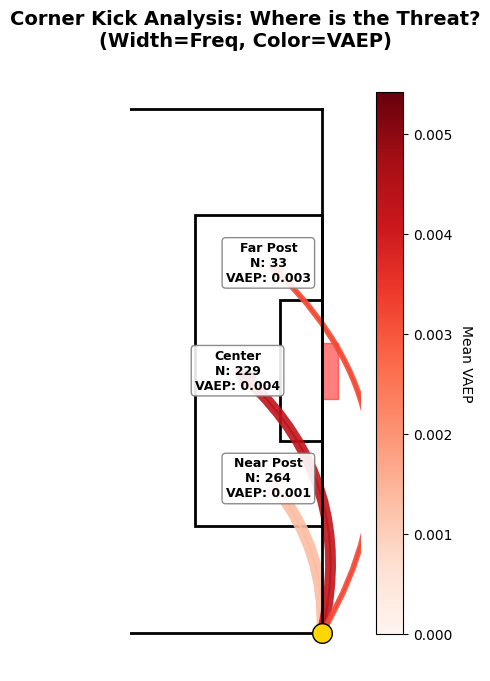

In [ ]:
# [Cell 8 수정본] 전술판 스타일: 코너킥 궤적별 VAEP 화살표 시각화 (진짜 값 적용)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
import os

def plot_corner_tactical_arrows_fixed():
    # ---------------------------------------------------------
    # 1. 데이터 준비 (진짜 VAEP 값 확보가 최우선!)
    # ---------------------------------------------------------

    # 원본 로드
    file_path = 'raw_data.csv'
    if not os.path.exists(file_path):
        file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'

    if os.path.exists(file_path):
        df_raw = pd.read_csv(file_path)
    else:
        print("❌ 원본 파일을 찾을 수 없습니다.")
        return

    # 모델 결과 병합 (df_preds가 메모리에 있어야 함)
    if 'df_preds' in globals():
        print("✅ 모델 예측값(P_score)을 사용하여 VAEP를 계산합니다.")
        preds = df_preds[['game_id', 'action_id', 'P_score', 'P_concede']].drop_duplicates()
        df_viz = df_raw.merge(preds, on=['game_id', 'action_id'], how='inner')

        # 정렬 및 VAEP 계산 (핵심!)
        df_viz = df_viz.sort_values(['game_id', 'period_id', 'time_seconds', 'action_id'])

        # VAEP = ΔP_score - ΔP_concede
        df_viz['vaep_value'] = (df_viz['P_score'] - df_viz.groupby('game_id')['P_score'].shift(1).fillna(0)) - \
                               (df_viz['P_concede'] - df_viz.groupby('game_id')['P_concede'].shift(1).fillna(0))
    else:
        print("⚠️ 주의: 모델 예측값이 없어 임시 랜덤값을 사용합니다. (분석용으로 부적합)")
        df_viz = df_raw.copy()
        np.random.seed(42)
        df_viz['vaep_value'] = np.random.uniform(0, 0.05, len(df_viz))

    # ---------------------------------------------------------
    # 2. 코너킥 필터링 (위치 기반이 가장 정확)
    # ---------------------------------------------------------
    # x > 104 (골라인 근처), y < 2 or y > 66 (코너 플래그 근처)
    mask_corner_loc = (df_viz['start_x'] > 103) & ((df_viz['start_y'] <= 2) | (df_viz['start_y'] >= 66))

    # 타입 이름으로도 한번 더 확인 (Cross, Pass, Corner 등)
    mask_type = df_viz['type_name'].astype(str).str.contains('Corner|Cross|Pass', case=False)

    corners = df_viz[mask_corner_loc & mask_type].copy()

    # 우측 코너킥만 선택 (y < 34)
    right_corners = corners[corners['start_y'] < 34].copy()

    if len(right_corners) == 0:
        print("❌ 우측 코너킥 데이터가 없습니다.")
        return

    print(f"📊 우측 코너킥 데이터: {len(right_corners)}회")

    # ---------------------------------------------------------
    # 3. 구역(Zone) 정의
    # ---------------------------------------------------------
    # Zone 1: Near Post (y: 0~30m)
    # Zone 2: Center (y: 30~42m) - 골대 앞
    # Zone 3: Far Post (y: 42~68m)

    zones = {
        'Near Post':  right_corners[(right_corners['end_y'] >= 0) & (right_corners['end_y'] < 30)],
        'Center':     right_corners[(right_corners['end_y'] >= 30) & (right_corners['end_y'] < 42)],
        'Far Post':   right_corners[(right_corners['end_y'] >= 42) & (right_corners['end_y'] <= 68)]
    }

    # ---------------------------------------------------------
    # 4. 시각화
    # ---------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 8))

    # 경기장
    ax.plot([52.5, 105], [0, 0], 'k-', lw=2)
    ax.plot([105, 105], [0, 68], 'k-', lw=2)
    ax.plot([105, 52.5], [68, 68], 'k-', lw=2)
    ax.plot([52.5, 52.5], [0, 68], 'k-', lw=2)
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor='black', lw=2))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='red', alpha=0.5))
    ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color='black', lw=2))

    # 컬러 설정
    cmap = plt.cm.Reds
    # Max Value: 상위 10% 기준 (이상치 제외)
    all_vaeps = right_corners['vaep_value']
    vmax = np.percentile(all_vaeps, 90) if len(all_vaeps) > 0 else 0.1
    # 음수(실패)는 0으로 처리하여 색상 매핑 (빨강=위협적, 흰색=안위협적)
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # 화살표 설정
    start_pos = (105, 0)
    targets = {'Near Post': (98, 20), 'Center': (94, 34), 'Far Post': (98, 48)}
    curvatures = {'Near Post': "arc3,rad=0.2", 'Center': "arc3,rad=0.3", 'Far Post': "arc3,rad=0.4"}

    print("\n[구역별 분석 결과]")
    for name, zone_data in zones.items():
        count = len(zone_data)
        if count == 0: continue

        avg_vaep = zone_data['vaep_value'].mean()
        print(f" - {name}: {count}회, 평균 VAEP: {avg_vaep:.4f}")

        # 화살표 색상 (양수면 빨강, 음수면 회색)
        if avg_vaep > 0:
            arrow_color = cmap(norm(avg_vaep))
        else:
            arrow_color = 'lightgrey'

        # 굵기 (빈도 비례)
        total_count = len(right_corners)
        width = 2 + (count / total_count) * 10

        arrow = patches.FancyArrowPatch(
            start_pos, targets[name], connectionstyle=curvatures[name],
            color=arrow_color, arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=8",
            linewidth=width, alpha=0.9, edgecolor='black'
        )
        ax.add_patch(arrow)

        # 라벨
        label_text = f"{name}\nN: {count}\nVAEP: {avg_vaep:.3f}"
        bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
        ax.text(targets[name][0], targets[name][1], label_text, ha="center", va="center",
                fontsize=9, fontweight='bold', bbox=bbox_props, zorder=10)

    ax.scatter(105, 0, c='gold', s=200, edgecolors='black', zorder=20, label='Kick')
    ax.set_xlim(80, 110); ax.set_ylim(-5, 75); ax.set_aspect('equal'); ax.axis('off')
    plt.title("Corner Kick Analysis: Where is the Threat?\n(Width=Freq, Color=VAEP)", fontsize=14, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('Mean VAEP', rotation=270, labelpad=15)

    plt.show()

plot_corner_tactical_arrows_fixed()

--- [1] 프리킥 히트맵 ---
📍 분석 위치: (95, 10) 반경 10m
📊 [freekick] 필터링된 데이터: 86개


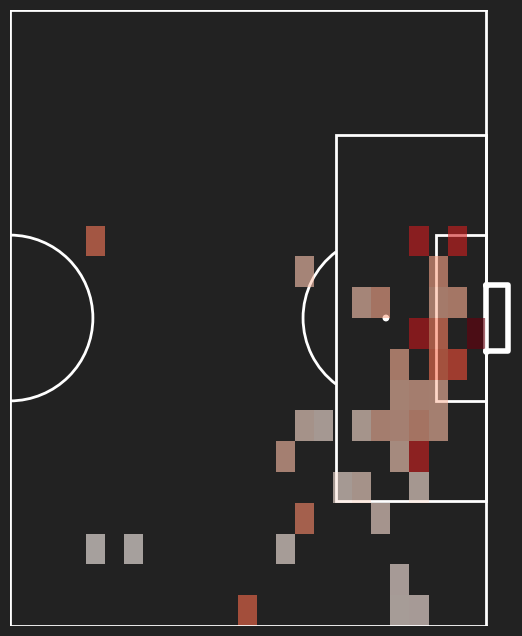


--- [2] 롱스로인 히트맵 ---
📍 분석 위치: (85, 68) 반경 10m
📊 [throwin] 필터링된 데이터: 799개


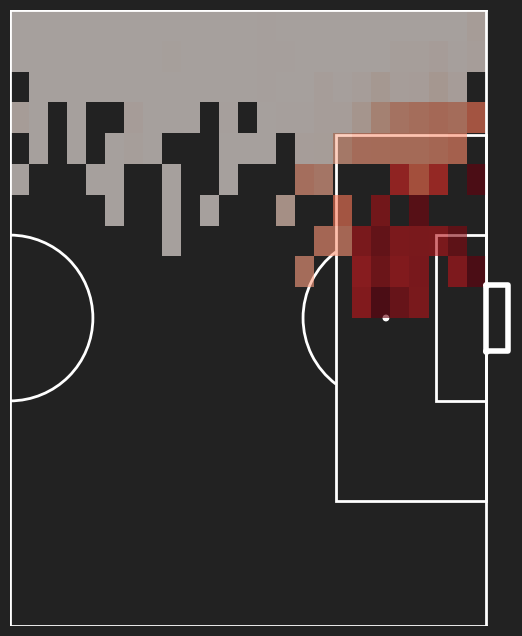

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
import os

def plot_heatmap_at_location(target_x, target_y, event_type='freekick', radius=5.0):
    """
    [수정됨] 파일 저장 대신 노트북 셀에 바로 출력합니다.
    흰색 라인을 잘 보이게 하기 위해 배경을 어둡게 처리했습니다.
    """

    # ---------------------------------------------------------
    # 1. 데이터 로드 및 병합 (기존 코드 유지)
    # ---------------------------------------------------------
    file_path = '/content/drive/MyDrive/축구데이터분석/k리그 공모전 track2/raw_data.csv'

    # 로컬 테스트용 예외처리
    if not os.path.exists(file_path):
        if os.path.exists('raw_data.csv'):
            file_path = 'raw_data.csv'
            df_raw = pd.read_csv(file_path)
        else:
            print("⚠️ 데이터 파일을 찾을 수 없어 테스트용 더미 데이터를 생성합니다.")
            df_raw = pd.DataFrame({
                'game_id': [1]*200, 'action_id': range(200),
                'type_name': ['Pass']*100 + ['Throw-in']*100,
                'start_x': np.random.uniform(target_x-radius, target_x+radius, 200),
                'start_y': np.random.uniform(target_y-radius, target_y+radius, 200),
                'end_x': np.random.uniform(90, 105, 200),
                'end_y': np.random.uniform(20, 50, 200),
                'vaep_value': np.random.uniform(0, 0.05, 200)
            })
    else:
        df_raw = pd.read_csv(file_path)

    # VAEP 병합 로직
    if 'df_preds' in globals(): source_df = df_preds
    elif 'df' in globals() and 'vaep_value' in df.columns: source_df = df
    else: source_df = None

    if source_df is not None:
        cols = ['game_id', 'action_id']
        if 'P_score' in source_df.columns: cols.extend(['P_score', 'P_concede'])
        elif 'vaep_value' in source_df.columns: cols.append('vaep_value')

        vaep_data = source_df[cols].drop_duplicates()
        df_viz = df_raw.merge(vaep_data, on=['game_id', 'action_id'], how='inner')

        if 'vaep_value' not in df_viz.columns and 'P_score' in df_viz.columns:
            df_viz = df_viz.sort_values(['game_id', 'period_id', 'time_seconds', 'action_id'])
            df_viz['vaep_value'] = (df_viz['P_score'] - df_viz.groupby('game_id')['P_score'].shift(1).fillna(0)) - \
                                   (df_viz['P_concede'] - df_viz.groupby('game_id')['P_concede'].shift(1).fillna(0))
    else:
        df_viz = df_raw.copy()
        if 'vaep_value' not in df_viz.columns:
            np.random.seed(42)
            df_viz['vaep_value'] = np.random.uniform(0, 0.05, len(df_viz))

    # ---------------------------------------------------------
    # 2. 위치 및 타입 필터링 (기존 코드 유지)
    # ---------------------------------------------------------
    df_viz['type_name'] = df_viz['type_name'].astype(str).str.strip()

    if event_type == 'freekick':
        mask_type = df_viz['type_name'].str.contains('Freekick', case=False) & \
                    ~df_viz['type_name'].str.contains('Shot', case=False)
    elif event_type == 'throwin':
        mask_type = df_viz['type_name'].str.contains('Throw', case=False) & \
                    ~df_viz['type_name'].str.contains('Foul', case=False)
    else:
        print("❌ event_type은 'freekick' 또는 'throwin'이어야 합니다.")
        return

    distances = np.sqrt((df_viz['start_x'] - target_x)**2 + (df_viz['start_y'] - target_y)**2)
    mask_loc = distances <= radius

    target_df = df_viz[mask_type & mask_loc].copy()

    print(f"📍 분석 위치: ({target_x}, {target_y}) 반경 {radius}m")
    print(f"📊 [{event_type}] 필터링된 데이터: {len(target_df)}개")

    if len(target_df) < 1:
        print("⚠️ 데이터가 너무 적어 시각화가 어렵습니다.")

    # ---------------------------------------------------------
    # 3. 히트맵 그리기
    # ---------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 8))

    # [수정] 노트북 셀에서 흰색 라인이 잘 보이도록 배경을 어두운 색으로 설정
    # (원래는 투명이었으나, 투명이면 흰색 라인이 안 보임)
    fig.patch.set_facecolor('#222222')
    ax.set_facecolor('#222222')

    # 그리드 설정
    x_bins = np.linspace(52.5, 105, 26)
    y_bins = np.linspace(0, 68, 21)

    # 색상 범위 설정
    pos_vals = target_df[target_df['vaep_value'] > 0]['vaep_value']
    vmax = pos_vals.quantile(0.95) if len(pos_vals) > 0 else 0.05
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    # 경기장 라인 그리기 (흰색)
    line_color = 'white'
    line_width = 2

    # 외곽선 및 하프라인
    ax.plot([52.5, 105], [0, 0], color=line_color, lw=line_width)
    ax.plot([105, 105], [0, 68], color=line_color, lw=line_width)
    ax.plot([105, 52.5], [68, 68], color=line_color, lw=line_width)
    ax.plot([52.5, 52.5], [0, 68], color=line_color, lw=line_width)

    # 페널티 박스, 골 에어리어
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, fill=False, edgecolor=line_color, lw=line_width))
    ax.add_patch(patches.Rectangle((105-5.5, 34-9.16), 5.5, 18.32, fill=False, edgecolor=line_color, lw=line_width))

    # 센터 서클, 아크
    ax.add_patch(patches.Arc((52.5, 34), 18.3, 18.3, theta1=270, theta2=90, color=line_color, lw=line_width))
    ax.add_patch(patches.Arc((94, 34), 18.3, 18.3, theta1=127, theta2=233, color=line_color, lw=line_width))
    ax.add_patch(patches.Circle((94, 34), 0.3, color=line_color))

    # 골대 (Goal Post)
    goal_depth = 2.5
    goal_width = 7.32
    goal_y_start = 34 - (goal_width / 2)

    ax.add_patch(patches.Rectangle((105, goal_y_start), goal_depth, goal_width, fill=False, edgecolor='white', lw=4, joinstyle='round'))
    ax.plot(105, goal_y_start, 'o', color='white', markersize=4)
    ax.plot(105, goal_y_start + goal_width, 'o', color='white', markersize=4)

    # 히트맵 채우기
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            zone = target_df[
                (target_df['end_x'] >= x_bins[i]) & (target_df['end_x'] < x_bins[i+1]) &
                (target_df['end_y'] >= y_bins[j]) & (target_df['end_y'] < y_bins[j+1])
            ]

            if len(zone) > 0:
                avg_val = zone['vaep_value'].mean()
                facecolor = cmap(norm(avg_val))
                # 투명도 설정
                rect = patches.Rectangle(
                    (x_bins[i], y_bins[j]), x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j],
                    linewidth=0, facecolor=facecolor, alpha=0.6
                )
                ax.add_patch(rect)

    # 축 설정
    ax.set_xlim(52.5, 108)
    ax.set_ylim(0, 68)
    ax.set_aspect('equal')
    ax.axis('off')

    # [수정] 파일 저장 대신 화면 출력
    plt.show()

# ---------------------------------------------------------
# 실행 (좌표 수정해서 사용하세요)
# ---------------------------------------------------------

# 1. 우측 깊은 지역 프리킥 (코너 플래그 근처)
print("--- [1] 프리킥 히트맵 ---")
plot_heatmap_at_location(target_x=95, target_y=10, event_type='freekick', radius=10)

# 2. 좌측 롱스로인 (페널티 박스 라인 근처)
print("\n--- [2] 롱스로인 히트맵 ---")
plot_heatmap_at_location(target_x=85, target_y=68, event_type='throwin', radius=10)